In [13]:
!pip3 install torch torchvision numpy matplotlib tk

    pytz (>=2011n)
         ~~~~~~~^


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

project_dir = str(Path().resolve().parent.parent)

In [15]:
class MNISTDataset(Dataset):
    def __init__(self,datadir,transform,is_train = True):
        super().__init__()
        self.datadir = datadir
        self.img,self.label = self.load_data(self.datadir, is_train = is_train)
        self.len_data = len(self.img)
        self.transform = transform
        
    def __getitem__(self,index):
        return self.transform(self.img[index]), self.label[index]
    
    def __len__(self):
        return self.len_data
    
    def load_data(self, datadir, is_train):
        dirname = os.path.join(datadir)
        files = ['train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz',
            't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz']

        paths = []
        for fname in files:
            paths.append(os.path.join(dirname,fname))
        if is_train:

            with gzip.open(paths[0], 'rb') as lbpath:
                label = np.frombuffer(lbpath.read(), np.uint8, offset=8)
            with gzip.open(paths[1], 'rb') as imgpath:
                img = np.frombuffer(imgpath.read(), np.uint8,
                                   offset=16).reshape(len(label), 28, 28)
        else:
            with gzip.open(paths[2], 'rb') as lbpath:
                label = np.frombuffer(lbpath.read(), np.uint8, offset=8)

            with gzip.open(paths[3], 'rb') as imgpath:
                img = np.frombuffer(imgpath.read(), np.uint8,
                                      offset=16).reshape(len(label), 28, 28)
        return img, label

Data shape: torch.Size([1, 28, 28])
Label: 5


/Users/Shared/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1710229037279/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


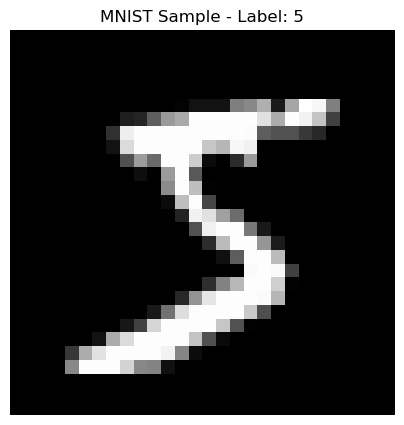

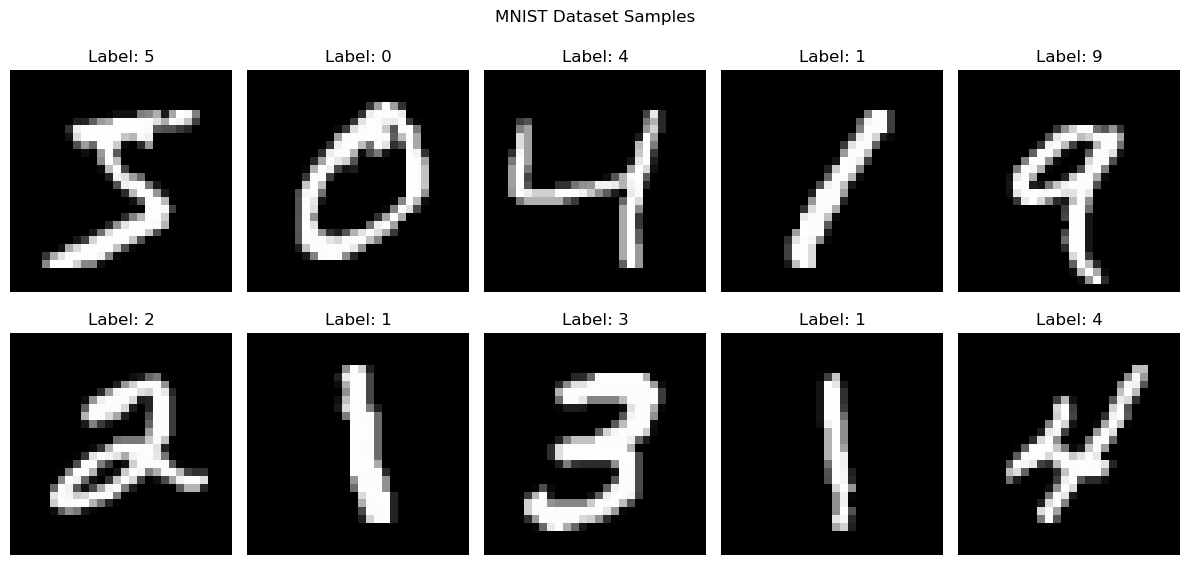

Dataset sizes:
Training set: 60000 samples
Test set: 10000 samples


In [16]:
"""MNIST Dataset"""
# Create datasets
train_dataset = MNISTDataset(
    datadir=os.path.join(project_dir, 'data/MNIST/raw'),
    transform=T.ToTensor(),
    is_train=True
)
test_dataset = MNISTDataset(
    datadir=os.path.join(project_dir, 'data/MNIST/raw'),
    transform=T.ToTensor(),
    is_train=False
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False, drop_last=False)

# Get a sample and display it
data, target = train_dataset[0]
print(f"Data shape: {data.shape}")
print(f"Label: {target}")

# Display the image
plt.figure(figsize=(5, 5))
plt.imshow(data.squeeze(), cmap='gray')
plt.title(f"MNIST Sample - Label: {target}")
plt.axis('off')
plt.show()

# Display multiple samples
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("MNIST Dataset Samples")

for i, ax in enumerate(axes.flat):
    data, target = train_dataset[i]
    ax.imshow(data.squeeze(), cmap='gray')
    ax.set_title(f"Label: {target}")
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Dataset sizes:")
print(f"Training set: {len(train_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

In [17]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
model = SimpleNN() # 实例化模型
loss_fn = nn.CrossEntropyLoss() # 损失函数：交叉熵损失
opt = torch.optim.Adam(model.parameters(), lr=1e-3) # 定义优化器

In [19]:
'''训练代码'''
def train(epoch):
    model.train()
    total_loss = 0.
    for iter, (data, target) in enumerate(train_loader):
        opt.zero_grad()  # backward前梯度清零
        output = model(data)
        loss = loss_fn(output, target) # 计算损失
        loss.backward() # 误差反向传播，计算梯度
        opt.step() # 参数更新
        total_loss += loss.item()
    print(f'Train Epoch: {epoch} Loss: {total_loss/len(train_loader):.3f}')

In [20]:
'''测试代码'''
def test(epoch):
    model.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize the counter for correct predictions
    total = 0  # Initialize the counter for total samples

    with torch.no_grad():  # Disable gradient computation for efficiency
        for data, target in test_loader:
            outputs = model(data)  # Forward pass: compute the model output
            _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest score
            total += target.size(0)  # Increment the total number of samples
            correct += (predicted == target).sum().item()  # Count the number of correct predictions

    accuracy = 100 * correct / total  # Calculate the accuracy percentage
    print(f'Test Epoch: {epoch} Accuracy: {accuracy:.2f}%')  # Print the test results

In [21]:

for epoch in range(5):
    '''train'''
    train(epoch)
    '''test'''
    test(epoch)

Train Epoch: 0 Loss: 0.286
Test Epoch: 0 Accuracy: 95.31%
Train Epoch: 1 Loss: 0.118
Test Epoch: 1 Accuracy: 96.71%
Train Epoch: 2 Loss: 0.080
Test Epoch: 2 Accuracy: 97.30%
Train Epoch: 3 Loss: 0.061
Test Epoch: 3 Accuracy: 97.59%
Train Epoch: 4 Loss: 0.047
Test Epoch: 4 Accuracy: 97.79%


In [ ]:
import tkinter as tk
from PIL import Image, ImageDraw
import numpy as np
from torchvision import transforms

def predict_digit():
    # Convert the image to grayscale
    img = Image.fromarray(canvas_array).convert('L')
    
    # Normalize the image
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    img_tensor = transform(img).unsqueeze(0)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)
    
    result_label.config(text=f"Predicted digit: {predicted.item()}")

def clear_canvas():
    canvas.delete("all")
    canvas_array.fill(0)  # Fill with black (0) instead of white (255)

def paint(event):
    # Calculate the position in the 28x28 grid
    x = int(event.x * 28 / canvas_width)
    y = int(event.y * 28 / canvas_height)
    
    # Set the pixel and its neighbors to white (255) to create a 3-pixel wide line
    for dx in range(-1, 2):
        for dy in range(-1, 2):
            nx, ny = x + dx, y + dy
            if 0 <= nx < 28 and 0 <= ny < 28:
                canvas_array[ny, nx] = 255
    
    # Update the canvas display with a 3-pixel wide line
    canvas.create_rectangle((x-1)*10, (y-1)*10, (x+2)*10, (y+2)*10, fill="white", outline="white")

# Create main window
root = tk.Tk()
root.title("Digit Recognition")

# Create canvas
canvas_width, canvas_height = 280, 280
canvas = tk.Canvas(root, width=canvas_width, height=canvas_height, bg="black")
canvas.pack()

# Create image array (28x28)
canvas_array = np.zeros((28, 28), dtype=np.uint8)  # Initialize with black (0)

# Bind mouse events
canvas.bind("<B1-Motion>", paint)

# Create buttons and label
clear_button = tk.Button(root, text="Clear", command=clear_canvas)
clear_button.pack()

predict_button = tk.Button(root, text="Predict", command=predict_digit)
predict_button.pack()

result_label = tk.Label(root, text="Draw a digit and click Predict")
result_label.pack()

root.mainloop()
